## <font color = "red">初期設定</font>

In [1]:
#notye_book名の取得
from requests import get

name_notebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
name_notebook

'first_note.ipynb'

In [2]:
!pip install kaggle

In [3]:
# Google Colaboratory上からGoogle Drive上のファイルにアクセスできるようにする
from google.colab import drive
drive.mount('/content/drive')

# ~/.kaggleディレクトリを作成し、ここへDrive上のkaggle.jsonをコピーしてくる
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定（所有者⇒フル権限・その他無し）
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
%%time
#kaggleから"ubiquant-parquet"を保存
!kaggle datasets download -d robikscube/ubiquant-parquet -p /content

100% 12.5G/12.5G [04:46<00:00, 32.5MB/s]
100% 12.5G/12.5G [04:46<00:00, 46.8MB/s]
CPU times: user 3.89 s, sys: 705 ms, total: 4.59 s
Wall time: 4min 47s


In [5]:
#解凍用パス
import zipfile
with zipfile.ZipFile('/content/ubiquant-parquet.zip') as existing_zip:
    existing_zip.extractall('/content')


In [16]:
#テスト　kagglenotebookと同じverのlightgbmをインストール
!pip install lightgbm==3.3.1

     |████████████████████████████████| 2.0 MB 23.4 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [6]:
#pipインストールが必要なパッケージのインストール
!pip install japanize-matplotlib
!pip install optuna

     |████████████████████████████████| 4.1 MB 22.4 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=81d7ef2280e6f812c0ee07c7e8b17f52c2c4766df318e6fd4e911ab35e1c995b
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
     |████████████████████████████████| 308 kB 22.4 MB/s 
     |████████████████████████████████| 209 kB 46.7 MB/s 
     |████████████████████████████████| 80 kB 8.1 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 149 kB 51.1 MB/s 
     |████████████████████████████████| 112 kB 54.0 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=b7cd5fb8e4ca54130f9c39d917124d17899abdc9353c87e53909db41d15e897e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8

In [2]:
#ライブラリのインポート
import glob
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import optuna

#lgb用
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold
import optuna.integration.lightgbm as o_lgb

#警告を非表示
import warnings
warnings.simplefilter('ignore')

import time
#seaborn 可視化用
%matplotlib inline

#モデル保存用
import pickle

#省略表示のキャンセル
pd.set_option('display.max_columns', 10000000)
pd.set_option('display.max_rows', 10000000)

## <font color = "red">parquet datasetsの読み込み</font>

In [3]:
#Pathの設定
DATA_PATH = '/content/'

#省略表示のキャンセル
pd.set_option('display.max_columns', 10000000)
pd.set_option('display.max_rows', 10000000)

In [4]:
#%%time
train = pd.read_parquet(DATA_PATH + 'train_low_mem.parquet') 

# <font color = "red">EDA</font>

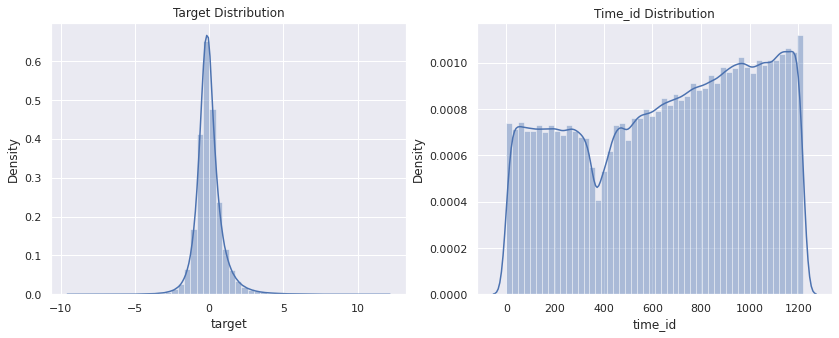

In [ ]:
#Target Distribution & Time_id Distribution
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.distplot(train['target'], ax=ax[0]).set_title('Target Distribution')
sns.distplot(train['time_id'], ax=ax[1]).set_title('Time_id Distribution')
fig.show()
plt.show()

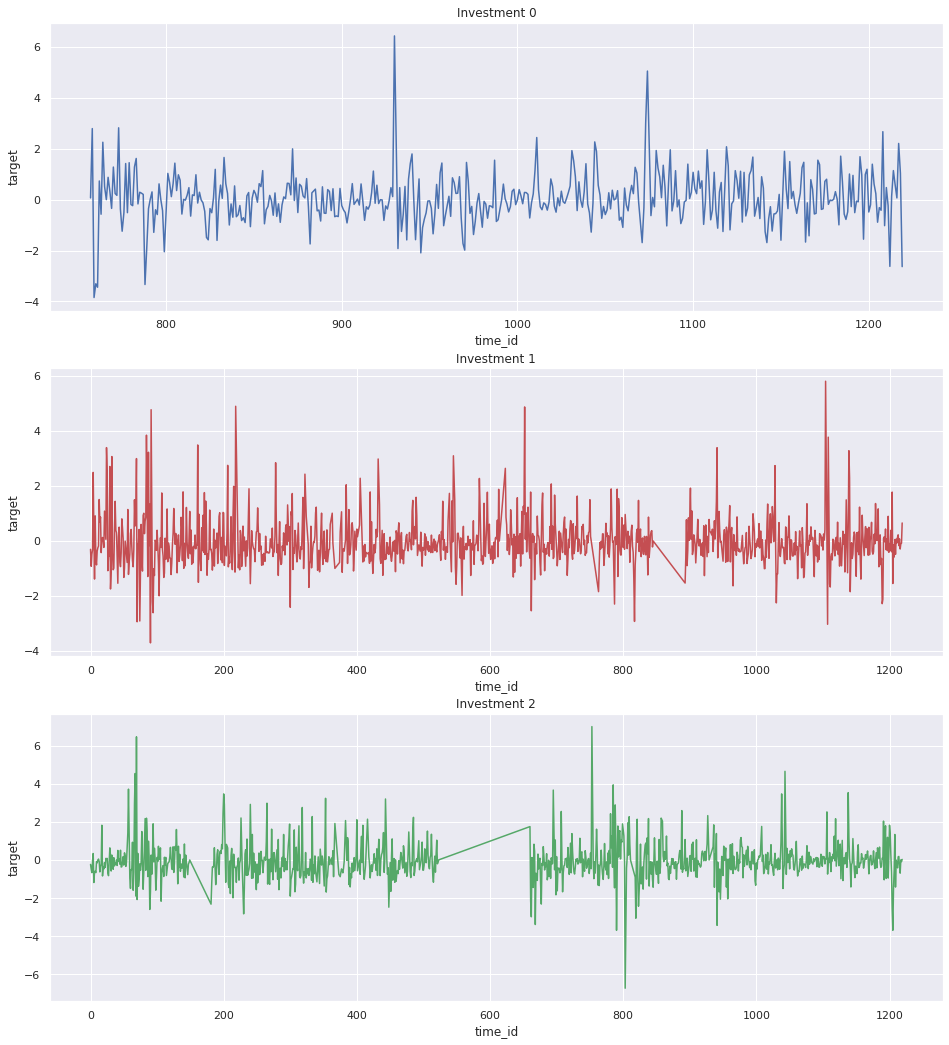

In [ ]:
#investment_id別targetの分布
sns.set_theme()
fig, ax =plt.subplots(3,1, figsize=(16, 18))
sns.lineplot(data=train[train['investment_id']==0],
             y=train[train['investment_id']==0]['target'],
             x=train[train['investment_id']==0]['time_id'],
             ax=ax[0]
            ).set_title('Investment 0')
sns.lineplot(data=train[train['investment_id']==1],
             y=train[train['investment_id']==1]['target'],
             x=train[train['investment_id']==1]['time_id'],
             ax=ax[1],
             color='r'
            ).set_title('Investment 1')
sns.lineplot(data=train[train['investment_id']==2],
             y=train[train['investment_id']==2]['target'],
             x=train[train['investment_id']==2]['time_id'],
             ax=ax[2],
             color='g'
            ).set_title('Investment 2')
fig.show()

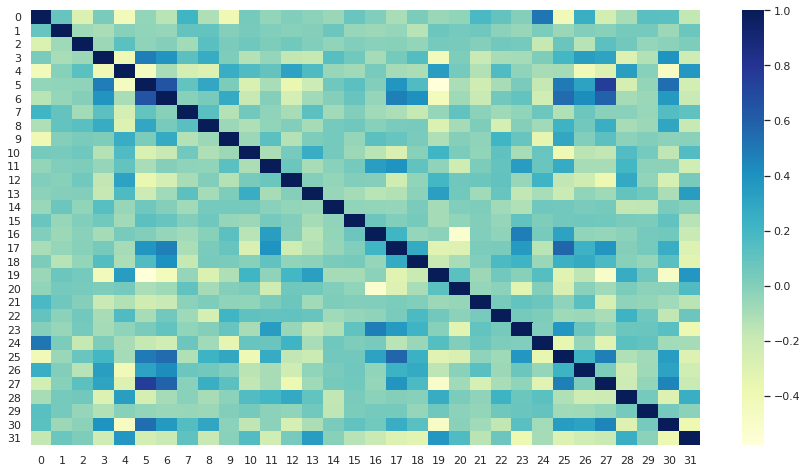

In [ ]:
#investment_id=0について、time_idとtargetと、特徴量1~30までの相関（図中,0=time_id,1=target）
investment_0 = train[train['investment_id']==0]
df = investment_0.drop(['row_id', 'investment_id'], axis=1)
del investment_0
df_30 = df.iloc[: , :32]
del df
corrMatrix = df_30.corr()
plt.figure(figsize = (15,8))
sns.heatmap(corrMatrix.to_numpy(), cmap="YlGnBu")

# <font color = "red">テスト用モデルの作成</font>

In [5]:
train[['f_0', 'f_1']].head()

,f_0,f_1
0,0.932573,0.113691
1,0.810802,-0.514115
2,0.393974,0.615937
3,-2.343535,-0.011870
4,0.842057,-0.262993


In [6]:
#submitテスト用にデータ数を制限
column_temp = train.columns.drop(['target', 'f_0', 'f_1' ])
train.drop(column_temp, axis=1, inplace=True)

In [7]:
train.head()

,target,f_0,f_1
0,-0.300875,0.932573,0.113691
1,-0.231040,0.810802,-0.514115
2,0.568807,0.393974,0.615937
3,-1.064780,-2.343535,-0.011870
4,-0.531940,0.842057,-0.262993


In [8]:
%%time
#lightGBM_データ準備
#train.drop(['row_id', 'time_id'], axis=1, inplace=True)
X = train.drop(['target'], axis=1)
y = train["target"]
del train
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
del X
del y


CPU times: user 119 ms, sys: 77 ms, total: 196 ms
Wall time: 194 ms


In [9]:
y_valid.shape

(314141,)

In [10]:
%%time
#lightGBM実行
model = LGBMRegressor(
        objective="regression",
        metric="rmse",
        boosting_type="gbdt",
        n_estimators=1400,
        num_leaves=100,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8
)

model.fit(X_train, y_train,
          eval_set=[(X_valid, y_valid)],
          verbose=2,
          eval_metric='rmse',
          early_stopping_rounds=400)

[2]	valid_0's rmse: 0.903935
[4]	valid_0's rmse: 0.903889
[6]	valid_0's rmse: 0.903852
[8]	valid_0's rmse: 0.903825
[10]	valid_0's rmse: 0.903804
[12]	valid_0's rmse: 0.903789
[14]	valid_0's rmse: 0.903779
[16]	valid_0's rmse: 0.903771
[18]	valid_0's rmse: 0.903765
[20]	valid_0's rmse: 0.903761
[22]	valid_0's rmse: 0.903757
[24]	valid_0's rmse: 0.903756
[26]	valid_0's rmse: 0.903756
[28]	valid_0's rmse: 0.903754
[30]	valid_0's rmse: 0.903757
[32]	valid_0's rmse: 0.903759
[34]	valid_0's rmse: 0.903763
[36]	valid_0's rmse: 0.903767
[38]	valid_0's rmse: 0.903771
[40]	valid_0's rmse: 0.903774
[42]	valid_0's rmse: 0.903774
[44]	valid_0's rmse: 0.903778
[46]	valid_0's rmse: 0.90378
[48]	valid_0's rmse: 0.903782
[50]	valid_0's rmse: 0.903783
[52]	valid_0's rmse: 0.903787
[54]	valid_0's rmse: 0.903792
[56]	valid_0's rmse: 0.903793
[58]	valid_0's rmse: 0.903795
[60]	valid_0's rmse: 0.903796
[62]	valid_0's rmse: 0.903799
[64]	valid_0's rmse: 0.903798
[66]	valid_0's rmse: 0.903803
[68]	valid_0's 

In [ ]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

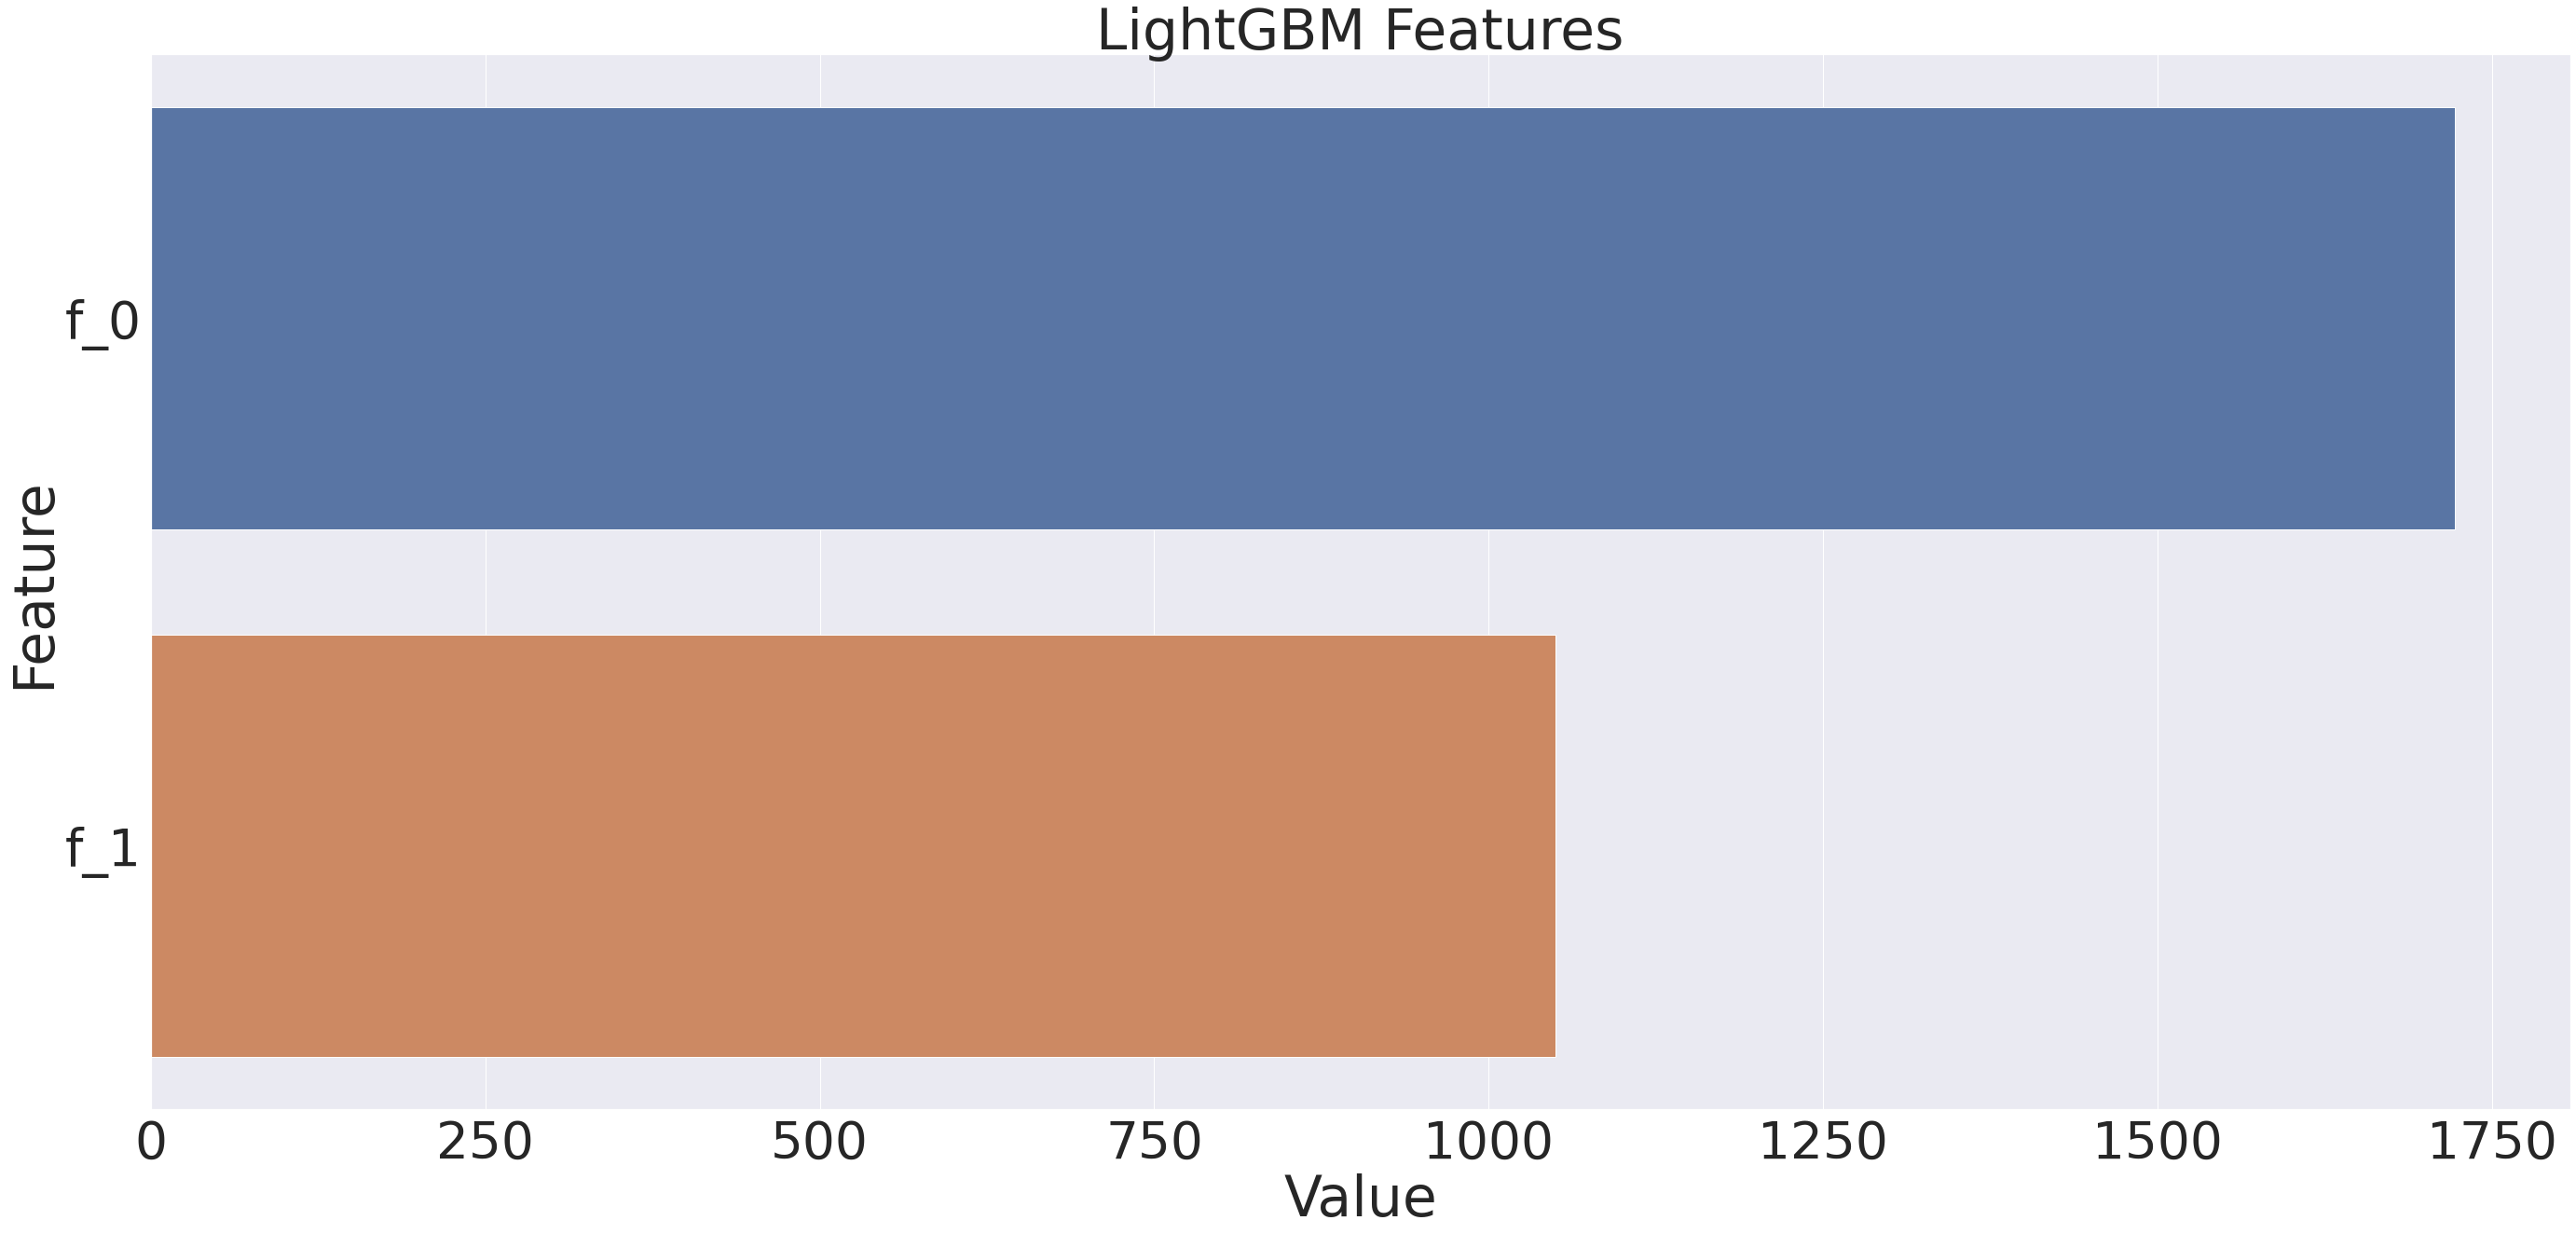

In [ ]:
plotImp(model, X_valid)

# <font color = "red">テスト用モデル作成2</font>

In [8]:
df = pd.DataFrame(np.arange(4).reshape(2, 2),
                 columns = ['f_0', 'f_1'],
                 index=['row0', 'row1'])
df

,f_0,f_1
row0,0,1
row1,2,3


In [9]:
feature_cols = [f'f_{i}' for i in range(300)]
df = pd.DataFrame(np.arange(3020).reshape(10, 302),
                 columns = [['target', 'investment_id'] + feature_cols],
                 index=['row0', 'row1', 'row2', 'row3', 'row4', 'row5', 'row6', 'row7', 'row8', 'row9'])
df

,target,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,f_80,f_81,f_82,f_83,f_84,f_85,f_86,f_87,f_88,f_89,f_90,f_91,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99,f_100,f_101,f_102,f_103,f_104,f_105,f_106,f_107,f_108,f_109,f_110,f_111,f_112,f_113,f_114,f_115,f_116,f_117,f_118,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_126,f_127,f_128,f_129,f_130,f_131,f_132,f_133,f_134,f_135,f_136,f_137,f_138,f_139,f_140,f_141,f_142,f_143,f_144,f_145,f_146,f_147,f_148,f_149,f_150,f_151,f_152,f_153,f_154,f_155,f_156,f_157,f_158,f_159,f_160,f_161,f_162,f_163,f_164,f_165,f_166,f_167,f_168,f_169,f_170,f_171,f_172,f_173,f_174,f_175,f_176,f_177,f_178,f_179,f_180,f_181,f_182,f_183,f_184,f_185,f_186,f_187,f_188,f_189,f_190,f_191,f_192,f_193,f_194,f_195,f_196,f_197,f_198,f_199,f_200,f_201,f_202,f_203,f_204,f_205,f_206,f_207,f_208,f_209,f_210,f_211,f_212,f_213,f_214,f_215,f_216,f_217,f_218,f_219,f_220,f_221,f_222,f_223,f_224,f_225,f_226,f_227,f_228,f_229,f_230,f_231,f_232,f_233,f_234,f_235,f_236,f_237,f_238,f_239,f_240,f_241,f_242,f_243,f_244,f_245,f_246,f_247,f_248,f_249,f_250,f_251,f_252,f_253,f_254,f_255,f_256,f_257,f_258,f_259,f_260,f_261,f_262,f_263,f_264,f_265,f_266,f_267,f_268,f_269,f_270,f_271,f_272,f_273,f_274,f_275,f_276,f_277,f_278,f_279,f_280,f_281,f_282,f_283,f_284,f_285,f_286,f_287,f_288,f_289,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
row0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301
row1,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,

In [10]:

#lightGBM_データ準備
#df.drop(['row_id', 'time_id'], axis=1, inplace=True)
X = df.drop(['target'], axis=1)
y = df[['target']]
#del df
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
#del X
#el y


In [13]:
model_test = LGBMRegressor(
        objective="regression",
        metric="rmse",
        boosting_type="gbdt",
        n_estimators=100,
        num_leaves=50,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8
)

model_test.fit(X_train, y_train,
          eval_set=[(X_valid, y_valid)],
          verbose=-1,
          eval_metric='rmse',
          early_stopping_rounds=50)

AttributeError: ignored

In [ ]:
model_test

LGBMRegressor(learning_rate=0.05, max_depth=10, metric='rmse', num_leaves=50,
              objective='regression', subsample=0.8)

In [ ]:
model_test.predict(X_valid)

array([-0.01079764, -0.0306648 , -0.01088958, ..., -0.01823456,
       -0.04199405, -0.01007331])

In [ ]:
#学習済みモデルの保存
file = '/content/drive/MyDrive/kaggle/models/test_model2.pkl'
pickle.dump(model_test, open(file, 'wb'))

In [ ]:
dataset_upload()

Starting upload for file test_model1.pkl


100%|██████████| 245k/245k [00:06<00:00, 36.8kB/s]


Upload successful: test_model1.pkl (245KB)
Starting upload for file test_model2.pkl


100%|██████████| 119k/119k [00:04<00:00, 27.0kB/s]


Upload successful: test_model2.pkl (119KB)
update


# <font color = "red">Kaggle Datasetへupload</font>

In [11]:
#学習済みモデルの保存
file = '/content/drive/MyDrive/kaggle/models/test_model3.pkl'
pickle.dump(model, open(file, 'wb'))

In [12]:
!kaggle datasets init -p '/content/drive/MyDrive/kaggle/models/'

Data package template written to: /content/drive/MyDrive/kaggle/models/dataset-metadata.json


In [ ]:
!kaggle datasets create -p '/content/drive/MyDrive/kaggle/models/'

Starting upload for file test_model1.pkl
100% 245k/245k [00:00<00:00, 539kB/s]
Upload successful: test_model1.pkl (245KB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/zin371/TEST--MODEL1


# <font color = "red">kaggledatasetに挙げたモデルの正常性検証</font>

In [ ]:
#kaggle datasetにあげたモデルのインポート
%%time
!kaggle datasets download -d zin371/test--model1 -p /content/temp

test--model1.zip: Skipping, found more recently modified local copy (use --force to force download)
CPU times: user 11.5 ms, sys: 23.4 ms, total: 34.8 ms
Wall time: 847 ms


In [ ]:
#解凍用パス
import zipfile
with zipfile.ZipFile('/content/temp/test--model1.zip') as existing_zip:
    existing_zip.extractall('/content/temp')


In [15]:
#モデルの読み込み
model_from_kaggle = pickle.load(open('/content/temp/test_model1.pkl', 'rb'))

FileNotFoundError: ignored

In [ ]:
pred_model_from_kaggle = model_from_kaggle.predict(X_valid)

In [ ]:
X_valid.tail()

,f_0,f_1
3141405,0.093530,-0.720275
3141406,-1.344935,-0.199987
3141407,0.979489,-1.110491
3141408,-2.565332,0.320301
3141409,-0.089557,0.190229


In [14]:
model_from_kaggle.fit(X_train, y_train,
          eval_set=[(X_valid, y_valid)],
          verbose=2,
          eval_metric='rmse',
          early_stopping_rounds=400)

NameError: ignored

In [ ]:
model_from_kaggle.predict(X_valid)

array([-0.01030942,  0.00547719, -0.00977656, ..., -0.01841434,
       -0.04322215, -0.00933482])

In [ ]:
#モデルの読み込み
model = pickle.load(open('/content/temp/test_model1.pkl', 'rb'))

In [ ]:
array = np.arange(301).T
df = pd.DataFrame(np.arange(4).reshape(2, 2),
                 columns = ['f_2', 'f_1'],
                 index=['row0', 'row1'])

In [ ]:
pred = model.predict(df)
pred

array([-0.06401756, -0.10372313])

In [ ]:
#datasetsのインポート
import_model = pickle.load(open('/content/drive/MyDrive/kaggle/models/test_model1.pkl', 'rb'))
import_model

LGBMRegressor(learning_rate=0.05, max_depth=10, metric='rmse',
              n_estimators=1400, num_leaves=100, objective='regression',
              subsample=0.8)

In [ ]:
pred=import_model.predict(X_valid)

In [ ]:
pred.shape

(314141,)

In [ ]:
y_valid.shape

(314141,)

In [ ]:
clf = lgb.LGBMClassifier()
clf.predict(X_valid)

NotFittedError: ignored

In [ ]:
X_train.shape

(2827269, 2)

# <font color = "red">currypanさんブログ記載　datasetへのアップロード関数</font>

In [13]:
#currypanさんブログ記載の、colab⇒kaggle datasetへのアップロードのセット
#url{https://zenn.dev/currypurin/scraps/e01410c6529e8e0d3af9}
UPLOAD_DIR = '/content/drive/MyDrive/kaggle/models/'
EX_NO = 'test-2'  # 実験番号などを入れる、folderのpathにする
#USERID = '6034474'
USERID = 'zin371'


def dataset_upload():
    import json
    from kaggle.api.kaggle_api_extended import KaggleApi

    id = f'{USERID}/{EX_NO}'

    dataset_metadata = {}
    dataset_metadata['id'] = id
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = f'{EX_NO}'

    with open(UPLOAD_DIR + 'dataset-metadata.json', 'w') as f:
        json.dump(dataset_metadata, f, indent=4)

    api = KaggleApi()
    api.authenticate()

    # データセットがない場合
    if f'{USERID}/{EX_NO}' not in [str(d) for d in api.dataset_list(user=USERID, search=f'"{EX_NO}"')]:
        api.dataset_create_new(folder=UPLOAD_DIR,
                               convert_to_csv=False,
                               dir_mode='skip')
        print('new upload')
    # データセットがある場合
    else:
        api.dataset_create_version(folder=UPLOAD_DIR,
                                   version_notes='update',
                                   convert_to_csv=False,
                                   delete_old_versions=True,
                                   dir_mode='skip')
        print('update')

In [14]:
dataset_upload()

Starting upload for file test_model1.pkl


100%|██████████| 245k/245k [00:00<00:00, 547kB/s]  


Upload successful: test_model1.pkl (245KB)
Starting upload for file test_model2.pkl


100%|██████████| 119k/119k [00:00<00:00, 179kB/s]  


Upload successful: test_model2.pkl (119KB)
Starting upload for file test_model3.pkl


100%|██████████| 278k/278k [00:00<00:00, 632kB/s]


Upload successful: test_model3.pkl (278KB)
update


In [ ]:
import json
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_create_version(folder=UPLOAD_DIR,
                        version_notes='update',
                        convert_to_csv=False,
                        delete_old_versions=True,
                        dir_mode='skip')

Starting upload for file test_model1.pkl


100%|██████████| 245k/245k [00:05<00:00, 49.1kB/s]


Upload successful: test_model1.pkl (245KB)


https://www.kaggle.com/zin371/test1_test